In [ ]:
# common packages 
import array
import numpy as np 
import os
import copy
from math import *
import matplotlib.pyplot as plt
import pydicom
import pandas as pd
import nmrglue as ng
import imio

In [2]:
def Dicom_Extract(data_path,output):
    """ For extracting data from dicom files, specifically dicom files without pixel data stored.
    Parameters
    ----------
    data_path : str or list of str
        Path to dicom file (formats tested: IMA)
    output : integers of either 0 or 1
        0 specifies an output of real and imaginary components separated, whereas 1 specifies a complex output
    Returns
    -------
    Real and Imaginary Data as lists, where real[0] returns first real element
    """
    
    ds = pydicom.dcmread(data_path, force=True)
    while True:
        try:
            return ds.pixel_array
        except:
            #Selecting CSA Data tag in Dicom file
            #Side note: MRI files usually have pixel data in 7fe0, 0010
            CSA_bytes = ds[(0x7fe1,0x1010)].value

            #converting bytes to list of values
            arr = array.array('f', CSA_bytes)
            MRS = arr.tolist()
            real_part = np.zeros((int(len(MRS)/2), 1))
            imag_part = real_part.copy()

            # sort into two columns or make complex
            k=0
            #len(MRS)-1
            for n in range(0,len(MRS)):
                if (n%2) == 0:
                    real_part[k] = MRS[n]
                    #print("This is Real:")
                    #print(real_part)
                else:
                    imag_part[k] = MRS[n]
                    #print("This is Imag:")
                    #print(imag_part)
                    k=k+1
            real = np.squeeze(real_part.tolist())
            imag = np.squeeze(imag_part.tolist())
            Real_acc=np.transpose(real)
            Real_acc=Real_acc.reshape((512, 4096), order='F')
            Imag_acc=np.transpose(imag)
            Imag_acc=Imag_acc.reshape((512, 4096), order='F')
            spectra = (Real_acc.astype(complex) + Imag_acc.astype(complex)*(0+1j)).reshape(512,4096)
            if output == 0:
                return Real_acc,Imag_acc
            if output == 1:
                return spectra

In [3]:
#specifying directory and gathering files
basedir = '/home/nraghu/Naren/MRI/DICOM/MRSI_Data/RMS01/MRS_SI_REF/'
myFiles = sorted(os.listdir(basedir))

In [39]:
#creating matrix of a singular patient's MRSI slices
#ONLY IF SELECTED OUTPUT IS 1(complex)
for k in range(len(myFiles)):
    signal = Dicom_Extract(basedir+str(myFiles[k]),1)
    if k==0:
        arr = signal
    else:
        arr = np.vstack((signal,arr))

In [41]:
#reshaping to correct form
Trans = arr.reshape(32,512,4096)

In [43]:
#Transposing data because data was in wrong order
temp = Trans.transpose([0, 2, 1]).reshape(32*4096, 512)

In [44]:
temp.shape

(131072, 512)

In [45]:
np.save('/data/bioprotean/Naren2/MRSI/RMS05_V2/RMS05_REF_unshaped.npy',temp)

In [28]:
temp = np.load('/data/bioprotean/Naren2/MRSI/RMS05_V2/RMS05_REF_unshaped.npy')

In [29]:
Matrix_trans = temp.reshape(32,4096, 512)

/packages/7x/anaconda3/5.3.0/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


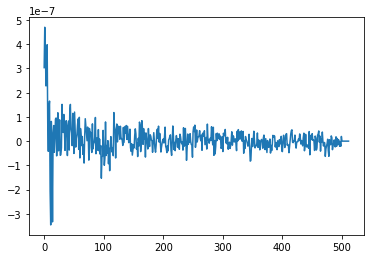

In [30]:
import matplotlib.pyplot as plt
plt.plot(Matrix_trans[13,2048,:])

In [40]:
#preprocessing fft
zero_filled = ng.proc_base.zf_size(temp, 2048)    # zero fill to 2048 points

In [41]:
FFT_data = ng.proc_base.fft(zero_filled)

In [43]:
#currently ADDING IMAGINARIES to FFT
#FFT_data1 = ng.proc_base.di(FFT_data) # discard the imaginaries
#FFT_data1 = np.absolute(FFT_data)

FFT_data1 = np.reshape(FFT_data, [32,4096,2048], order='C')

In [46]:
FFT_complex = np.stack( [FFT_data1.real, FFT_data1.imag], axis=3)

In [11]:
FFT_data2 = FFT_data_real[:,:,:,np.newaxis]

In [15]:
FFT_data1[0,0,0]

(4.638345060259397e-07+1.5968760014306582e-06j)

/packages/7x/anaconda3/5.3.0/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


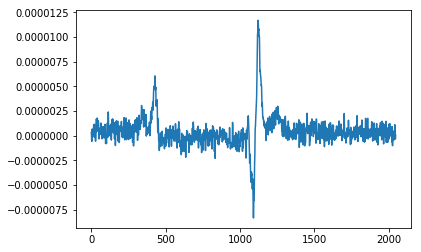

In [12]:
test = np.reshape(FFT_data, [32,4096,2048], order='C')
s2 = test[16,2040,:]
plt.plot(s2)

In [48]:
np.save('/data/bioprotean/Naren2/MRSI/RMS05_V2/RMS05_REF_complex_FFT.npy', FFT_complex)

In [23]:
d = np.load('/data/bioprotean/Naren2/MRSI/RMS02_V2/RMS02_complex_FFT.npy')

In [56]:
import nibabel as nib

ni_img = nib.Nifti1Image(FFT_complex, affine=np.eye(4))
nib.save(ni_img, "/data/bioprotean/Naren2/MRSI/RMS05_V2/RMS05_REF_complex_FFT.nii")

In [11]:
import nibabel as nib
x = nib.load("/data/bioprotean/Naren2/MRSI/RMS05_V2/RMS05_REF_complex_FFT.nii")

In [12]:
import numpy as np
a = np.array(x.dataobj)

In [31]:
a.shape

(32, 4096, 2048, 2)

In [13]:
a[:,:,:,0].shape

(32, 4096, 2048)

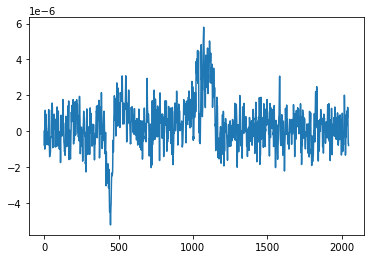

In [32]:
import matplotlib.pyplot as plt
plt.plot(a[13,2048,:,0])

In [21]:
import nibabel as nib
z = nib.load("/data/bioprotean/Naren2/MRSI/RMS05_V2/RMS05_complex_FFT.nii")

In [22]:
import numpy as np
b = np.array(z.dataobj)

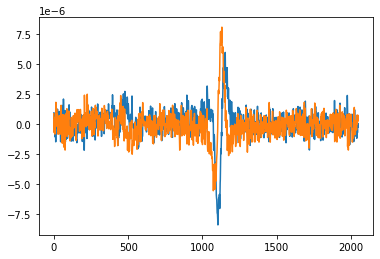

In [26]:
import matplotlib.pyplot as plt
plt.plot(b[13,2048,:])